In [129]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../')
from utils import quant
from utils import symbols

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import yfinance as yf
import ta
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tslearn
from tslearn.clustering import TimeSeriesKMeans
from neurodsp import sim #for brownian motion 
from math import log, floor
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pipeline

* Get tickers and their sectors (Prob need a better more up to date way of getting tickers)
* Compare PCA and SSA for finding similar patterns
    - Maybe do this on some sort of moving averages (how to figure out time windows?)
* Cluster

### Also
- DFA, brownian motion modelling


Refs
- http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/117-hcpc-hierarchical-clustering-on-principal-components-essentials/
- https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

Ticker CSV (keep in mind there are 70+ IPOS a year)

# SSA (missing eigentriple grouping) 

https://en.wikipedia.org/wiki/Singular_spectrum_analysis

trying on a year of data

A general formula for the number of rows in the trajectory matrix is n=nt−m+1, where nt is the length of the original time series vector

Would be interesting to make a function that visualizes where PCs of given time window occur in the data

In [64]:
tsla = yf.download('TSLA', '2019-01-01','2020-01-01')

[*********************100%***********************]  1 of 1 completed


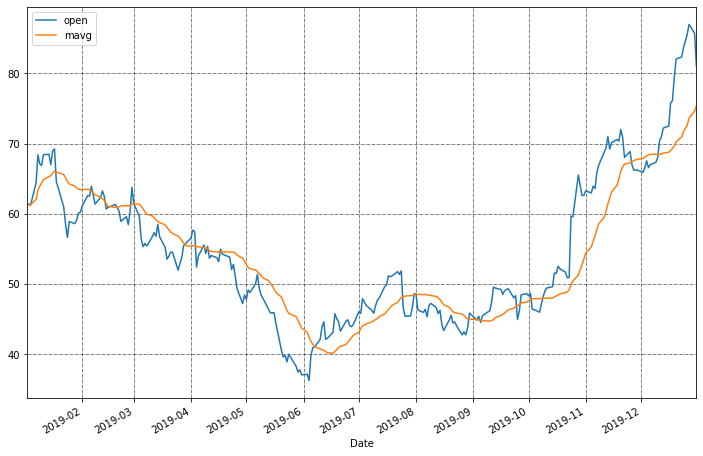

In [5]:
mavg20 = ta.volatility.bollinger_mavg(tsla['Open'], 20)

pd.DataFrame({
    'open': tsla['Open'],
    '20 day mavg': mavg20
}).plot(figsize=(12,8))

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

In [115]:
data = np.array(tsla['Close'])

co, spec, traj = quant.SSA(data, m = 32, step =7, return_traj = True)

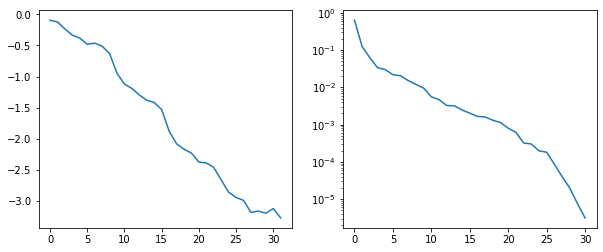

In [116]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(co[0]@traj) #First PC
plt.subplot(1,2,2)
plt.plot(spec); plt.yscale('log')

### Mass SSA on many tickers to cluster with tslearn kmeans

What time window to use?  What about time window and step size for SSA?
Do we want open data, close data?

Using tslearn kmeans: why does smoothness of cluster centroid drop from n=11 to 12 clusters? 
Based on observations, makes sense that it would resemble the PC1s a lot
Displaying cool cluster plot
- Want to look at [docs](https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py)

In [ ]:
tech = symbols.data_by_category(num=20,kwargs={'sector':'Technology'})

In [127]:
pc1s = []; sym = []
for k in tech.keys():
    sym.append(k)
    co, e, traj = quant.SSA(np.array(tech[k])/max(tech[k]), m = 31, step =15) # window of about a month
    pc1s.append(co[0]@traj)

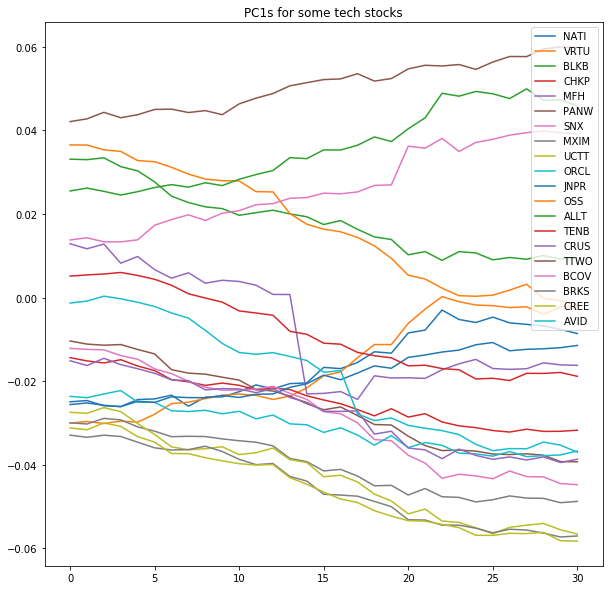

In [143]:
plt.figure(figsize=(10,10))
for i,k in zip(pc1s,sym):
    plt.plot(i,label=k)
    plt.legend(loc = 'upper right')
plt.title('PC1s for some tech stocks')
plt.show()

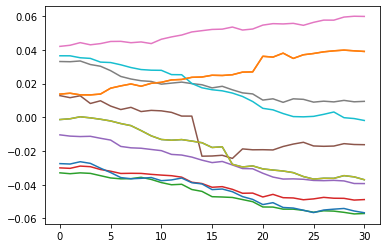

In [150]:
ts_data = tslearn.utils.to_time_series_dataset([t for t in pc1s])
model = TimeSeriesKMeans(n_clusters=12, metric="softdtw", max_iter=10)
model.fit(ts_data)
for c in model.cluster_centers_:
    plt.plot(c)